In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Data import and preprocessing

In [2]:
df = pd.read_csv("Radar_Traffic_Counts.csv")

In [3]:
df_new = df.copy()

In [4]:
df_new = df_new.sort_values(by = ["Year", "Month", "Day", "Day of Week"])

In [5]:
df_new.isnull().sum().max()

0

In [6]:
df_new.head()

,location_name,location_latitude,location_longitude,Year,Month,Day,Day of Week,Hour,Minute,Time Bin,Direction,Volume
627251,LAMAR BLVD / SHOAL CREEK BLVD,30.292767,-97.747190,2017,6,18,0,23,45,23:45,SB,10
627252,LAMAR BLVD / SHOAL CREEK BLVD,30.292767,-97.747190,2017,6,18,0,23,45,23:45,SB,16
627253,LAMAR BLVD / SHOAL CREEK BLVD,30.292767,-97.747190,2017,6,18,0,23,45,23:45,NB,35
627254,LAMAR BLVD / SHOAL CREEK BLVD,30.292767,-97.747190,2017,6,18,0,23,45,23:45,NB,26
627255,LAMAR BLVD / SANDRA MURAIDA WAY (Lamar Bridge),30.266800,-97.756051,2017,6,18,0,23,45,23:45,NB,44


There are no NAs in the dataset

#### We're going to see how many unique values we have for each column:

In [7]:
for i in list(df_new.columns):
    print(i," : ", len(df_new.loc[:,i].unique()))

location_name  :  23
location_latitude  :  18
location_longitude  :  18
Year  :  3
Month  :  12
Day  :  31
Day of Week  :  7
Hour  :  24
Minute  :  60
Time Bin  :  96
Direction  :  5
Volume  :  256


Let's take a look at our data types

In [8]:
df_new.dtypes

location_name          object
location_latitude     float64
location_longitude    float64
Year                    int64
Month                   int64
Day                     int64
Day of Week             int64
Hour                    int64
Minute                  int64
Time Bin               object
Direction              object
Volume                  int64
dtype: object

##### Let's transform object data into integer classes

In [9]:
mappings = {}

for i in range(df_new.shape[1]):
    if df_new.iloc[:,i].dtypes == 'O':
        labels_list=list(df_new.iloc[:,i].unique())
        mapping = dict(zip(labels_list,range(len(labels_list))))
        mappings[df_new.columns[i]] = (mapping)
        df_new.iloc[:,i] = df_new.iloc[:,i].map(mapping)

In [57]:
X = df_new.drop("Volume", axis = 1)
y = df_new.Volume

In [58]:
scaler = MinMaxScaler()
scaler.fit(np.array(y).reshape(-1,1))
y_scaled = scaler.transform(np.array(y).reshape(-1,1))

In [59]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [13]:
X_scaled = X_scaled[:20000, :]
y = y_scaled[:20000]

In [14]:

X_train, X_test = X_scaled[:16000], X_scaled[16000:]
y_train, y_test = y[:16000], y[16000:]
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 24)

In [15]:
class SelectDataset(Dataset):
    
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label
    

In [16]:
X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)
batch_size = 10
test = SelectDataset(X_test,y_test)
train = SelectDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size = batch_size,shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [32]:
class NN(nn.Module):
    
    def __init__(self):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(11,5)
        self.fc2 = nn.Linear(5,5)
        self.fc3 = nn.Linear(5,1)
        
    def forward(self,x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

train_losses = []


def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())
    
    print(f'train_loss {train_loss}')

test_losses = []

def Test():
    
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.detach().cpu().numpy())
        print(f'test_loss {test_loss}')
    


In [34]:
epochs = 300
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Test()

epochs 1/500
train_loss 0.09941383451223373
test_loss 0.09757551945328373
epochs 2/500
train_loss 0.08545634150505066
test_loss 0.08350722075451315
epochs 3/500
train_loss 0.07666344195604324
test_loss 0.07380588743210902
epochs 4/500
train_loss 0.0711856409907341
test_loss 0.06734688229958889
epochs 5/500
train_loss 0.0678892433643341
test_loss 0.06311359829561773
epochs 6/500
train_loss 0.06592654436826706
test_loss 0.060330815661387316
epochs 7/500
train_loss 0.06473733484745026
test_loss 0.058466702334628896
epochs 8/500
train_loss 0.06397126615047455
test_loss 0.05716291544065261
epochs 9/500
train_loss 0.06342840194702148
test_loss 0.056209192359435604
epochs 10/500
train_loss 0.06300375610589981
test_loss 0.055469959718790804
epochs 11/500
train_loss 0.06264036893844604
test_loss 0.05487049699556537
epochs 12/500
train_loss 0.062311332672834396
test_loss 0.0543634781801343
epochs 13/500
train_loss 0.062000822275877
test_loss 0.05391933433106533
epochs 14/500
train_loss 0.0617010

test_loss 0.01503081382905801
epochs 216/500
train_loss 0.021291324868798256
test_loss 0.015009465049348001
epochs 217/500
train_loss 0.021254591643810272
test_loss 0.01499546981670482
epochs 218/500
train_loss 0.021219300106167793
test_loss 0.01498496758382735
epochs 219/500
train_loss 0.021183177828788757
test_loss 0.014969077594887756
epochs 220/500
train_loss 0.02114955335855484
test_loss 0.014952133100748052
epochs 221/500
train_loss 0.0211169570684433
test_loss 0.01493616010491908
epochs 222/500
train_loss 0.021084146574139595
test_loss 0.014922865661826714
epochs 223/500
train_loss 0.021052371710538864
test_loss 0.01490961144792034
epochs 224/500
train_loss 0.021020883694291115
test_loss 0.014895666642940711
epochs 225/500
train_loss 0.020991023629903793
test_loss 0.014883181843542455
epochs 226/500
train_loss 0.020961372181773186
test_loss 0.014867632761237372
epochs 227/500
train_loss 0.020933562889695168
test_loss 0.014853364570438794
epochs 228/500
train_loss 0.0209054257720

KeyboardInterrupt: 

<function matplotlib.pyplot.show(*args, **kw)>

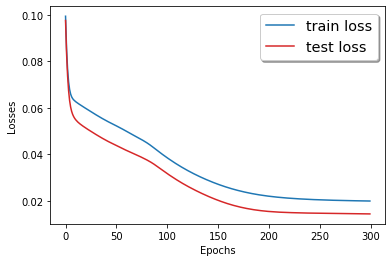

In [36]:


fig, ax = plt.subplots()
color = "tab:blue"
ax.plot(range(len(train_losses)), train_losses, color = color, label = "train loss")

color = "tab:red"
ax.plot(range(len(test_losses)), test_losses, color = color, label = "test loss")

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
ax.set_xlabel("Epochs")
ax.set_ylabel("Losses")

plt.show

In [37]:
inputs = X_test.float().to(device)
y_predict = model(inputs)

In [38]:
y_pred = []
y_testing = []

for i in y_predict.tolist():
    y_pred.append(i[0])
    
for i in y_test.tolist():
    y_testing.append(i[0])


<function matplotlib.pyplot.show(*args, **kw)>

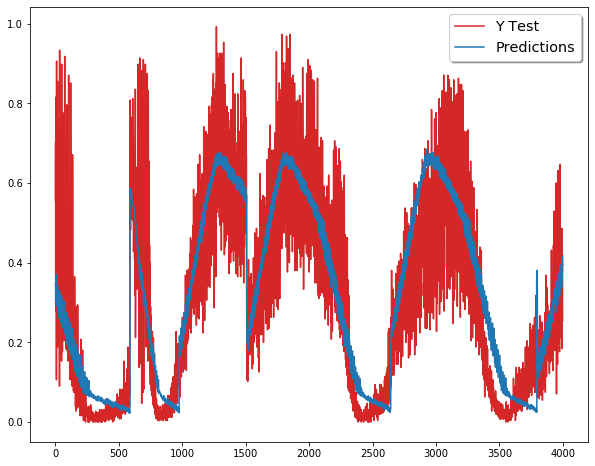

In [40]:
fig, ax = plt.subplots(figsize = (10,8))


color = "tab:red"
ax.plot(range(len(y_testing)), y_testing, color = color, label = "Y Test")

color = "tab:blue"
ax.plot(range(len(y_pred)), y_pred, color = color, label = "Predictions")

Legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')


plt.show

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1 = NN().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)
criterion = nn.SmoothL1Loss()

train_losses_huber = []


def Train_huber():
    
    running_loss = .0
    
    model1.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model1(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses_huber.append(train_loss.detach().cpu().numpy())
    
    print(f'train_loss {train_loss}')

test_losses_huber = []

def Test_huber():
    
    running_loss = .0
    
    model1.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model1(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses_huber.append(test_loss.detach().cpu().numpy())
        print(f'test_loss {test_loss}')
    


In [43]:
epochs = 300
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train_huber()
    Test_huber()

epochs 1/300
train_loss 0.1510680466890335
test_loss 0.11204025968816657
epochs 2/300
train_loss 0.12944898009300232
test_loss 0.09182253097857428
epochs 3/300
train_loss 0.10887674242258072
test_loss 0.0737482892490209
epochs 4/300
train_loss 0.0900852158665657
test_loss 0.05828533267583328
epochs 5/300
train_loss 0.07361707091331482
test_loss 0.04559096518961773
epochs 6/300
train_loss 0.05985844507813454
test_loss 0.03583345572225502
epochs 7/300
train_loss 0.04920610785484314
test_loss 0.029702279613326416
epochs 8/300
train_loss 0.041784171015024185
test_loss 0.026760703262694446
epochs 9/300
train_loss 0.037195902317762375
test_loss 0.02565319180311937
epochs 10/300
train_loss 0.03449643403291702
test_loss 0.02525572162878663
epochs 11/300
train_loss 0.032808490097522736
test_loss 0.025007654630420238
epochs 12/300
train_loss 0.03161892667412758
test_loss 0.024738641838087883
epochs 13/300
train_loss 0.030686620622873306
test_loss 0.02442955559439541
epochs 14/300
train_loss 0.02

test_loss 0.008110864427477231
epochs 214/300
train_loss 0.010885210707783699
test_loss 0.008103626725737136
epochs 215/300
train_loss 0.010873948223888874
test_loss 0.008097801663008511
epochs 216/300
train_loss 0.01086251251399517
test_loss 0.008091326953833508
epochs 217/300
train_loss 0.010851440951228142
test_loss 0.00808883657183347
epochs 218/300
train_loss 0.010839911177754402
test_loss 0.008081838177166805
epochs 219/300
train_loss 0.01082855835556984
test_loss 0.008076551786315667
epochs 220/300
train_loss 0.01081755943596363
test_loss 0.008071154221856634
epochs 221/300
train_loss 0.010807136073708534
test_loss 0.008064435104648573
epochs 222/300
train_loss 0.010796851478517056
test_loss 0.008058218388232934
epochs 223/300
train_loss 0.010787173174321651
test_loss 0.008051436711741506
epochs 224/300
train_loss 0.010777534916996956
test_loss 0.008047151653258621
epochs 225/300
train_loss 0.010767610743641853
test_loss 0.008044486990644875
epochs 226/300
train_loss 0.010757292

<function matplotlib.pyplot.show(*args, **kw)>

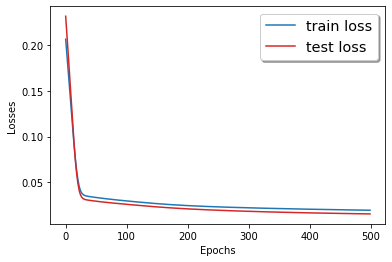

In [172]:


fig, ax = plt.subplots()
color = "tab:blue"
ax.plot(range(len(train_losses_huber)), train_losses_huber, color = color, label = "train loss")

color = "tab:red"
ax.plot(range(len(test_losses_huber)), test_losses_huber, color = color, label = "test loss")

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
ax.set_xlabel("Epochs")
ax.set_ylabel("Losses")

plt.show

In [78]:
inputs = X_test.float().to(device)
y_predict = model1(inputs)

In [79]:
y_pred = []
y_testing = []

for i in y_predict.tolist():
    y_pred.append(i[0])
    
for i in y_test.tolist():
    y_testing.append(i[0])


## Save CSV

In [76]:
training_NN_Huber_loss = []
test_NN_Huber_loss= []
for i in train_losses:
    training_NN_Huber_loss.append(float(i))
    
for i in test_losses:
    test_NN_Huber_loss.append(float(i))

In [77]:
import csv

with open("train_loss_Huber.csv", 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(training_NN_Huber_loss)

with open("test_loss_Huber.csv", 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(test_NN_Huber_loss)


## CNN

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1d = nn.Conv1d(1,32,kernel_size= 3, stride = 1)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool1d(3, stride=1)
        self.fc1 = nn.Linear(7 * 32,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1,7*32)
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.SmoothL1Loss()

train_losses = []


def Train_CNN():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.view(-1,1,11)
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())
    
    print(f'train_loss {train_loss}')

test_losses = []

def Test_CNN():
    
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.view(-1,1,11)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.detach().cpu().numpy())
        print(f'test_loss {test_loss}')
    


In [68]:
epochs = 300
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train_CNN()
    Test_CNN()

epochs 1/300
train_loss 0.036483049392700195
test_loss 0.028867794763395207
epochs 2/300
train_loss 0.03512836992740631
test_loss 0.028023102021387636
epochs 3/300
train_loss 0.03363405540585518
test_loss 0.02707678355127643
epochs 4/300
train_loss 0.03254618123173714
test_loss 0.026318235435771452
epochs 5/300
train_loss 0.031228281557559967
test_loss 0.025443786125010852
epochs 6/300
train_loss 0.030007166787981987
test_loss 0.02483512100017526
epochs 7/300
train_loss 0.029141118749976158
test_loss 0.023909577994454808
epochs 8/300
train_loss 0.02847302332520485
test_loss 0.023146013107396494
epochs 9/300
train_loss 0.027570830658078194
test_loss 0.022388635909318756
epochs 10/300
train_loss 0.02673601172864437
test_loss 0.021778348205727438
epochs 11/300
train_loss 0.025849761441349983
test_loss 0.021014097576872004
epochs 12/300
train_loss 0.02508402243256569
test_loss 0.02029148776008333
epochs 13/300
train_loss 0.024690056219697
test_loss 0.019848265084652334
epochs 14/300
train_

train_loss 0.011853517964482307
test_loss 0.00985281318292647
epochs 109/300
train_loss 0.012085096910595894
test_loss 0.009910803818039236
epochs 110/300
train_loss 0.012092910706996918
test_loss 0.009881878177735576
epochs 111/300
train_loss 0.011881126090884209
test_loss 0.009817460590664252
epochs 112/300
train_loss 0.012201927602291107
test_loss 0.009931552956958294
epochs 113/300
train_loss 0.012002430856227875
test_loss 0.00995321042361877
epochs 114/300
train_loss 0.011879058554768562
test_loss 0.009854763153603521
epochs 115/300
train_loss 0.011873360723257065
test_loss 0.009861400961342599
epochs 116/300
train_loss 0.011839110404253006
test_loss 0.00995383544355401
epochs 117/300
train_loss 0.011765195056796074
test_loss 0.009858771525179829
epochs 118/300
train_loss 0.011896880343556404
test_loss 0.010002625070261267
epochs 119/300
train_loss 0.011773446574807167
test_loss 0.009976717640912937
epochs 120/300
train_loss 0.011864511296153069
test_loss 0.009844698525565665
epoc

KeyboardInterrupt: 

<function matplotlib.pyplot.show(*args, **kw)>

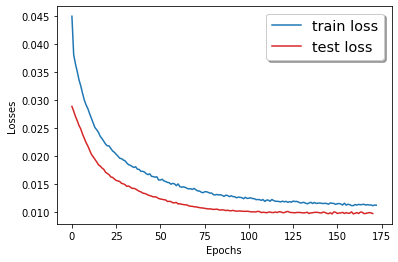

In [69]:


fig, ax = plt.subplots()
color = "tab:blue"
ax.plot(range(len(train_losses)), train_losses, color = color, label = "train loss")

color = "tab:red"
ax.plot(range(len(test_losses)), test_losses, color = color, label = "test loss")

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
ax.set_xlabel("Epochs")
ax.set_ylabel("Losses")

plt.show

## RNN

In [146]:
X_test = X_scaled[20000:24000]
y_test = y_scaled[20000:24000]
X_train = X_scaled[:16000]
y_train = y_scaled[:16000]

In [147]:
X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)
X_train, X_test = X_train.view(-1,2,11), X_test.view(-1, 2, 11)
y_train, y_test = y_train.view(-1, 2), y_test.view(-1,2)

In [148]:
batch_size = 10
test = SelectDataset(X_test,y_test)
train = SelectDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size = batch_size,shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [149]:
for idx, (inputs,labels) in enumerate(train_loader):
    print(labels.size())
    break

torch.Size([10, 2])


In [154]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        x, hn = self.rnn(x, h0.detach())


        # Index hidden state of last time step
        # out.size() --> 100, 28, 10
        # out[:, -1, :] --> 100, 10 --> just want last time step hidden states! 
        x = self.fc(x[:, -1, :])
        # out.size() --> 100, 10
        return x

In [155]:
input_dim = 11
hidden_dim = 100
layer_dim = 1
output_dim = 2

model = RNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.SmoothL1Loss()

train_losses = []


def Train_RNN():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())
    
    print(f'train_loss {train_loss}')

test_losses = []

def Test_RNN():
    
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.detach().cpu().numpy())
        print(f'test_loss {test_loss}')
    


In [156]:
epochs = 300
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train_RNN()
    Test_RNN()

epochs 1/300
train_loss 0.08406472951173782
test_loss 0.05325673034845943
epochs 2/300
train_loss 0.04663853719830513
test_loss 0.03316321340228837
epochs 3/300
train_loss 0.03355616331100464
test_loss 0.028147974877559902
epochs 4/300
train_loss 0.030050354078412056
test_loss 0.026310842219266814
epochs 5/300
train_loss 0.02827681414783001
test_loss 0.024925096706715097
epochs 6/300
train_loss 0.026890238747000694
test_loss 0.023714054162548494
epochs 7/300
train_loss 0.025650646537542343
test_loss 0.022625412603248178
epochs 8/300
train_loss 0.024549409747123718
test_loss 0.021749049526026142
epochs 9/300
train_loss 0.023599538952112198
test_loss 0.021001598847104407
epochs 10/300
train_loss 0.022764496505260468
test_loss 0.02034845628446353
epochs 11/300
train_loss 0.02201901189982891
test_loss 0.019766111711224596
epochs 12/300
train_loss 0.02134782448410988
test_loss 0.019249224699807697
epochs 13/300
train_loss 0.020747359842061996
test_loss 0.01879321505753171
epochs 14/300
trai

epochs 108/300
train_loss 0.00988275371491909
test_loss 0.010880249242909043
epochs 109/300
train_loss 0.009858353063464165
test_loss 0.010874308962360586
epochs 110/300
train_loss 0.009834459982812405
test_loss 0.010868969785138512
epochs 111/300
train_loss 0.009810365736484528
test_loss 0.010862641454024706
epochs 112/300
train_loss 0.009786473587155342
test_loss 0.010855310086803405
epochs 113/300
train_loss 0.009762829169631004
test_loss 0.010849925860095772
epochs 114/300
train_loss 0.009739462286233902
test_loss 0.010843000436706938
epochs 115/300
train_loss 0.009716200642287731
test_loss 0.01083603352287341
epochs 116/300
train_loss 0.009693107567727566
test_loss 0.010827447369398573
epochs 117/300
train_loss 0.009669959545135498
test_loss 0.010821992298856718
epochs 118/300
train_loss 0.009647437371313572
test_loss 0.010815667147857998
epochs 119/300
train_loss 0.009624823927879333
test_loss 0.010809392294464402
epochs 120/300
train_loss 0.009602333419024944
test_loss 0.0108019

train_loss 0.008243178017437458
test_loss 0.009649781662013987
epochs 214/300
train_loss 0.008233859203755856
test_loss 0.00963324974757226
epochs 215/300
train_loss 0.008224520832300186
test_loss 0.009615367456802002
epochs 216/300
train_loss 0.008215288631618023
test_loss 0.009599282147909815
epochs 217/300
train_loss 0.008206172846257687
test_loss 0.009583648842179897
epochs 218/300
train_loss 0.008197195827960968
test_loss 0.009568987538629429
epochs 219/300
train_loss 0.008188453502953053
test_loss 0.009554312643799938
epochs 220/300
train_loss 0.008179651573300362
test_loss 0.009539478598314262
epochs 221/300
train_loss 0.00817076861858368
test_loss 0.009524883817495338
epochs 222/300
train_loss 0.008161905221641064
test_loss 0.009510129994086087
epochs 223/300
train_loss 0.00815319363027811
test_loss 0.009495945891893003
epochs 224/300
train_loss 0.008144525811076164
test_loss 0.009479558145366052
epochs 225/300
train_loss 0.008135946467518806
test_loss 0.009463730638347859
epoc

<function matplotlib.pyplot.show(*args, **kw)>

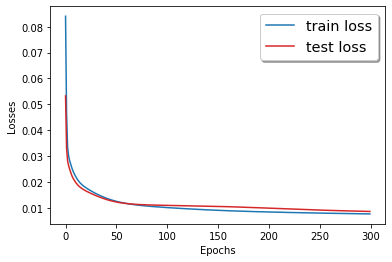

In [157]:
fig, ax = plt.subplots()
color = "tab:blue"
ax.plot(range(len(train_losses)), train_losses, color = color, label = "train loss")

color = "tab:red"
ax.plot(range(len(test_losses)), test_losses, color = color, label = "test loss")

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
ax.set_xlabel("Epochs")
ax.set_ylabel("Losses")

plt.show